## Assumptions:

Aroon is a quite popular among technical analysts, it is supposed to detect trend reversals changes in asset prices.
I think that Aroon is too granular, espcially for low to mid float stocks with low market depth.
Detecting the convexity of the curved formed by successive prices (the line generated would be a polynomial fit) of low float stocks over an extended time period should give a better signal than Aroon.

In [9]:
import pandas as pd

import yfinance as yf
from talib import MA_Type
import talib
import numpy as np
from datetime import datetime, timedelta 
from time import gmtime, strftime
from csv import writer
import os
import sqlite3

from utils.db_manage import DBManager, QuRetType, dfToRDS, std_db_acc_obj
db_acc_obj = std_db_acc_obj() 


In [3]:
"""
qu = f"SELECT * FROM NASDAQ_15 WHERE DATE > '2020-7-01'"
initialDF = db_acc_obj.exc_query(db_name='marketdata', query=qu, \
retres=QuRetType.ALLASPD)
initialDF.to_csv('nasdaq_marketdata.csv')
"""

'\nqu = f"SELECT * FROM NASDAQ_15 WHERE DATE > \'2020-7-01\'"\ninitialDF = db_acc_obj.exc_query(db_name=\'marketdata\', query=qu, retres=QuRetType.ALLASPD)\ninitialDF.to_csv(\'nasdaq_marketdata.csv\')\n'

In [3]:
dfTick = pd.read_csv('nasdaq_marketdata.csv')
dfTick = dfTick.loc[dfTick['Symbol']=='IDXG']
#  : Convex

In [4]:
dfTick

,Unnamed: 0,Symbol,Date,Open,High,Low,Close,Volume
1587,1587,IDXG,2020-07-02,5.10,6.640,4.7701,6.14,5352400
5038,5038,IDXG,2020-07-03,6.14,6.140,6.1400,6.14,0
8491,8491,IDXG,2020-07-06,6.38,6.800,5.6200,6.36,1220200
11945,11945,IDXG,2020-07-07,5.83,6.340,5.4500,5.53,419200
15403,15403,IDXG,2020-07-08,5.43,5.703,5.1100,5.19,259600
...,...,...,...,...,...,...,...,...
558385,558385,IDXG,2021-02-08,4.95,5.470,4.9300,5.29,264100
562432,562432,IDXG,2021-02-09,5.30,5.790,5.1900,5.70,295200
566493,566493,IDXG,2021-02-10,5.86,5.900,5.2900,5.44,165100
570556,570556,IDXG,2021-02-11,5.43,5.990,5.3900,5.61,226800


4.006860759493671
[0.00000e+00 1.00000e+00 2.00000e+00 ... 5.74626e+05 5.74627e+05
 5.74628e+05]
Equation:  3.40084416586108e-11*x**2 - 2.16721136530297e-5*x + 6.47718211957627


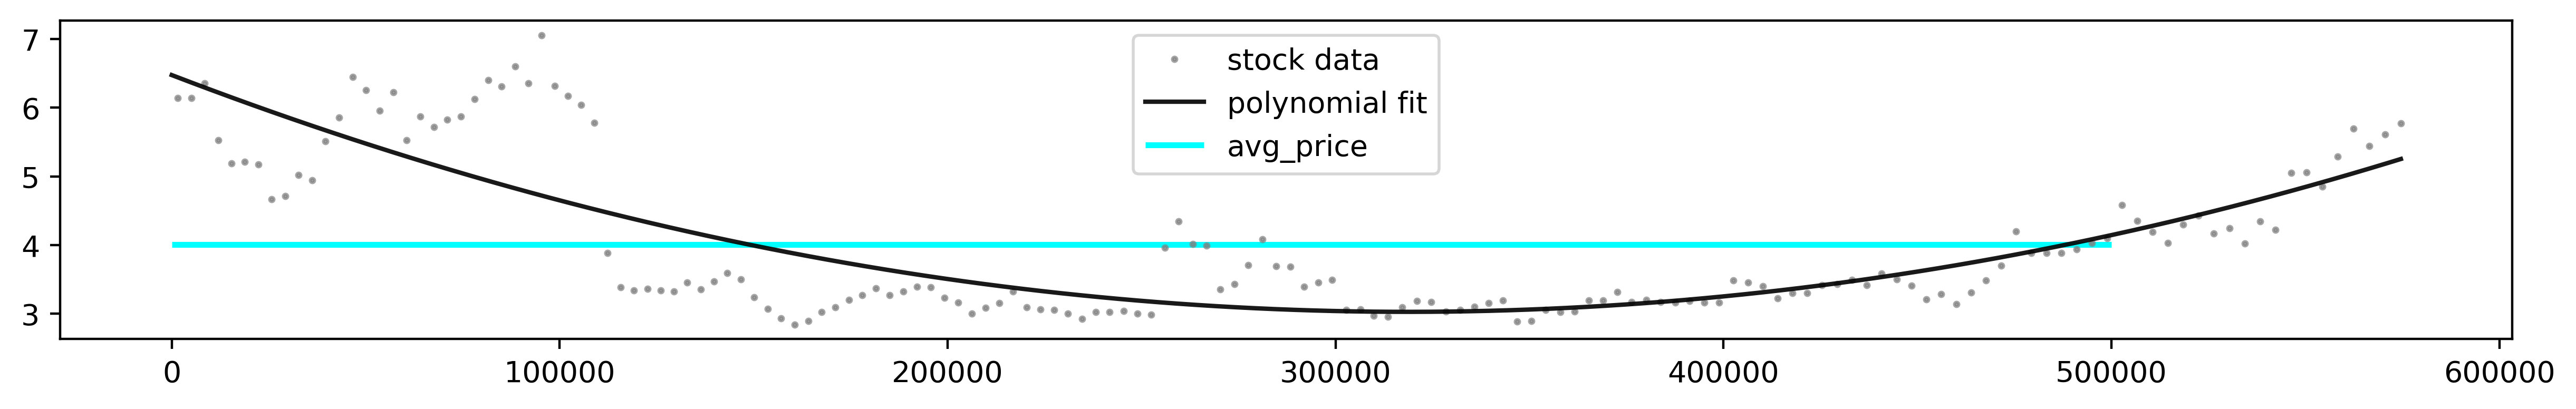

In [18]:
import matplotlib.pyplot as plt
from sympy import Symbol,expand

# discretization of the dataset
x_data = dfTick.index.tolist()
y_data = dfTick.Close.tolist()

avg_price = np.average(y_data)
print(avg_price)

x = np.linspace(0, max(dfTick.index.tolist()), max(dfTick.index.tolist()) + 1)
print(x)
# polynomial fit of degree xx
pol = np.polyfit(x_data, y_data, 2)
y_pol = np.polyval(pol, x)


# Printing out the equation
y1=np.poly1d(pol)
test=Symbol('x')
print("Equation: ", expand(y1(test)))


plt.figure(figsize=(15, 2), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(x_data, y_data, 'o', markersize=1.5, color='grey', alpha=0.7)
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.hlines(y=avg_price, xmin=0, xmax=500000, colors='aqua', linestyles='-', lw=2, label='Single Short Line')
plt.legend(['stock data', 'polynomial fit', 'avg_price'])
plt.show()


# To do: assess the level of conexity on degree 2 or 3
# Set a threshold of convexity
# Assumption, the first point needs to be higher than the last one or start above the average price

In [12]:
# https://en.wikipedia.org/wiki/Curve_fitting

In [7]:
from sympy import S, symbols, printing
